In [3]:
pip install dill

  Using cached https://files.pythonhosted.org/packages/52/d6/79f40d230895fa1ce3b6af0d22e0ac79c65175dc069c194b79cc8e05a033/dill-0.3.3-py2.py3-none-any.whl
You are using pip version 10.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

import time
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
import dill
import pickle
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import shap

In [22]:
random_seed = 123


print("start")

start_time = time.time()

#df_eco = pd.read_parquet("./harmonized-table__envonly.parquet")
df_eco = pd.read_csv("./harmonized-table_onlyenv_nona_num.tsv", sep="\t", encoding="utf-8")


exec_time = (time.time() - start_time)
print('seconds ' + str(exec_time))



start
seconds 0.05515098571777344


In [23]:

df_eco.shape


(44674, 11)

In [24]:
print(df_eco.describe())

         Unnamed: 0  samp_salinity     altitude   taxonomy_id    fire  \
count  4.467400e+04      76.000000  5972.000000  4.467400e+04   150.0   
mean   6.759576e+06       7.726447    38.528801  6.123975e+05  2004.0   
std    3.700029e+06       0.381711   424.608695  3.914641e+05     0.0   
min    1.955900e+04       7.100000     0.000000  2.000000e+00  2004.0   
25%    4.219819e+06       7.440000     0.000000  4.106580e+05  2004.0   
50%    5.772072e+06       8.000000     0.000000  4.127550e+05  2004.0   
75%    8.678785e+06       8.000000     0.000000  9.399280e+05  2004.0   
max    1.429602e+07       8.000000  5450.000000  2.742685e+06  2004.0   

        num_replicons  light_intensity  entrez_value  biosample_id  \
count      383.000000        52.000000  4.637000e+03  4.467400e+04   
mean      2873.796345     26950.969231  8.175037e+05  7.192416e+06   
std      51339.056773     21088.525193  3.709119e+06  4.016092e+06   
min          1.000000      4900.000000  4.540000e+02  2.620600

In [61]:
df_eco_small = df_eco.drop(['Unnamed: 0','taxonomy_id','fire','entrez_value','biosample_id','host_taxid'], axis=1)

In [62]:
df_eco_small = df_eco_small.fillna(0)

In [63]:
df_eco_small.astype(bool).sum(axis=0)

samp_salinity             76
altitude                  57
num_replicons            383
light_intensity           52
annual_season_precpt    1255
dtype: int64

In [64]:
df_eco_small.astype(bool).sum(axis=1)

0        0
1        0
2        0
3        0
4        0
        ..
44669    0
44670    0
44671    0
44672    0
44673    0
Length: 44674, dtype: int64

In [65]:
df_eco_small = df_eco_small.loc[~(df_eco_small==0).all(axis=1)]

In [66]:
df_eco_small.shape

(1823, 5)

In [67]:
df_eco_small.columns

Index(['samp_salinity', 'altitude', 'num_replicons', 'light_intensity',
       'annual_season_precpt'],
      dtype='object')

In [68]:
y = df_eco_small['light_intensity']
print(y)

print("df_eco "+str(df_eco.shape))

X = df_eco_small.drop('light_intensity', 1)#df_eco.iloc[:,:-1]

print("X "+str(X.shape))

27       0.0
289      0.0
290      0.0
291      0.0
292      0.0
        ... 
28809    0.0
28810    0.0
28818    0.0
37591    0.0
39971    0.0
Name: light_intensity, Length: 1823, dtype: float64
df_eco (44674, 11)
X (1823, 4)


In [69]:
y.describe()

count     1823.000000
mean       768.760505
std       5708.530002
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      85422.800000
Name: light_intensity, dtype: float64

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_seed) #, random_state=9# The seed was 'chosen' so test and training contain all labels: rn=3,4,8,9
print("train label deficit:",len(set(y)-set(y_train)),"test label deficit:",len(set(y)-set(y_test)))

print("shapes "+str(X_train.shape)+"\t"+str(X_test.shape)+"\t"+str(y_train.shape)+"\t"+str(y_test.shape))

train_dataset = Pool(X_train, y_train)
test_dataset = Pool(X_test, y_test)

input_data_dump = [X, y, X_train, X_test, y_train, y_test]
pickle.dump(input_data_dump,open("input_data_dump", "wb" ) )

train label deficit: 0 test label deficit: 6
shapes (1367, 4)	(456, 4)	(1367,)	(456,)


In [71]:
modelstart = time.time()

print(f"Starting search at {modelstart}")
cb_model = CatBoostRegressor(loss_function='MAE',
                             iterations = 200,
                             verbose = 5,
                             learning_rate = 0.1,
                             depth = 3,
                             l2_leaf_reg = 0.5,
                             #eval_metric = 'MCC',
                             random_seed = random_seed,
                             #bagging_temperature = 0.2,
                             #od_type = 'Iter',
                             #od_wait = 100
)

grid = {#'iterations': [100, 150, 200],
       'learning_rate': [0.6, 0.8, 1],
        'depth': [3,4,5],
        'l2_leaf_reg': [2,3,4]}
grid_search_result = cb_model.grid_search(grid, train_dataset)

lr = grid_search_result['params']['learning_rate']
de = grid_search_result['params']['depth']
l2 = grid_search_result['params']['l2_leaf_reg']

print(f"Trained grid search in {time.time() - modelstart}s")

print("lr, de, l2 "+str(lr)+", "+str(de)+", "+str(l2))





Starting search at 1615492402.854468

bestTest = 854.6196956
bestIteration = 191

0:	loss: 854.6196956	best: 854.6196956 (0)	total: 231ms	remaining: 6s

bestTest = 854.6196934
bestIteration = 199

1:	loss: 854.6196934	best: 854.6196934 (1)	total: 442ms	remaining: 5.53s

bestTest = 854.6196939
bestIteration = 175

2:	loss: 854.6196939	best: 854.6196934 (1)	total: 647ms	remaining: 5.18s

bestTest = 854.6196956
bestIteration = 191

3:	loss: 854.6196956	best: 854.6196934 (1)	total: 877ms	remaining: 5.04s

bestTest = 854.6196948
bestIteration = 198

4:	loss: 854.6196948	best: 854.6196934 (1)	total: 1.08s	remaining: 4.77s

bestTest = 854.6196946
bestIteration = 197

5:	loss: 854.6196946	best: 854.6196934 (1)	total: 1.29s	remaining: 4.52s

bestTest = 854.6196956
bestIteration = 191

6:	loss: 854.6196956	best: 854.6196934 (1)	total: 1.59s	remaining: 4.54s

bestTest = 854.6196942
bestIteration = 199

7:	loss: 854.6196942	best: 854.6196934 (1)	total: 1.8s	remaining: 4.28s

bestTest = 854.6196946

In [72]:
modelstart = time.time()

print(f"Starting at {modelstart}")
cb_model = CatBoostRegressor(loss_function='MAE',
                             iterations = 200,
                             verbose = 5,
                             learning_rate = lr,
                             depth = de,
                             l2_leaf_reg = l2,
                             #eval_metric = 'MCC',
                             random_seed = random_seed,
                             #bagging_temperature = 0.2,
                             #od_type = 'Iter',
                             #od_wait = 100
)

cbmf = cb_model.fit(X_train, y_train)
print(f"Trained in {time.time() - modelstart}s")





Starting at 1615492426.000479
0:	learn: 827.0677330	total: 2.32ms	remaining: 462ms
5:	learn: 827.0677320	total: 11.5ms	remaining: 373ms
10:	learn: 827.0677320	total: 20.3ms	remaining: 348ms
15:	learn: 827.0677318	total: 27.2ms	remaining: 313ms
20:	learn: 827.0677318	total: 34.1ms	remaining: 291ms
25:	learn: 457.1745353	total: 39.6ms	remaining: 265ms
30:	learn: 457.1745353	total: 45ms	remaining: 246ms
35:	learn: 457.1745353	total: 50.8ms	remaining: 231ms
40:	learn: 457.1745353	total: 56.6ms	remaining: 219ms
45:	learn: 457.1745353	total: 62.4ms	remaining: 209ms
50:	learn: 457.1745353	total: 69.1ms	remaining: 202ms
55:	learn: 457.1745353	total: 74.9ms	remaining: 193ms
60:	learn: 457.1745353	total: 83.1ms	remaining: 189ms
65:	learn: 457.1745353	total: 89.5ms	remaining: 182ms
70:	learn: 457.1745353	total: 95.5ms	remaining: 173ms
75:	learn: 457.1745353	total: 101ms	remaining: 165ms
80:	learn: 457.1745353	total: 107ms	remaining: 158ms
85:	learn: 457.1745353	total: 114ms	remaining: 151ms
90:	l

In [73]:
pred_train = cb_model.predict(X_train)
rmseT = (np.sqrt(mean_squared_error(y_train, pred_train)))
r2T = r2_score(y_train, pred_train)
print("Testing performance:")
print('RMSE training: {:.2f}'.format(rmseT))
print('R2 training: {:.2f}'.format(r2T))




Testing performance:
RMSE training: 3891.60
R2 training: 0.60


In [84]:
cbmf.feature_names = X.columns

In [85]:
pred_test = cb_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred_test)))
r2 = r2_score(y_test, pred_test)
print("Testing performance:")
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))




Testing performance:
RMSE: 2178.10
R2: 0.73


In [86]:
explainer_model = shap.TreeExplainer(cb_model)
explainer_fit = shap.TreeExplainer(cbmf)

In [87]:
data_output = [random_seed, cb_model, cbmf, pred_train, explainer_model, pred_test, explainer_fit]
pickle.dump(data_output,open("data_output", "wb" ) )

Text(0.5, 0, 'CatBoost Feature Importance')

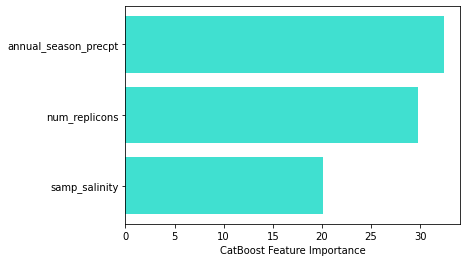

In [88]:
sorted_feature_importance = cb_model.feature_importances_.argsort()
plt.barh(cb_model.feature_names[sorted_feature_importance[1:100]],
        cb_model.feature_importances_[sorted_feature_importance[1:100]],
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

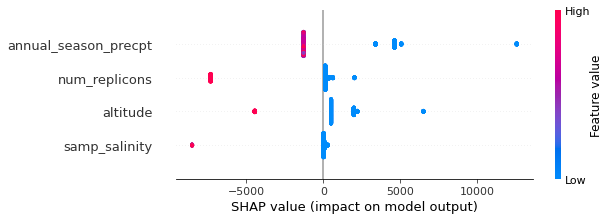

In [89]:
shap_values = explainer_model.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names = cb_model.feature_names[sorted_feature_importance],show=False)#,matplotlib=True).savefig('SHAP.pdf',bbox_inches = 'tight')



In [90]:
cbmf_all = cb_model.fit(X,y)

0:	learn: 768.7605004	total: 1.8ms	remaining: 359ms
5:	learn: 768.7604997	total: 12.2ms	remaining: 395ms
10:	learn: 768.7604994	total: 20.4ms	remaining: 351ms
15:	learn: 420.9777238	total: 27.3ms	remaining: 314ms
20:	learn: 420.9777239	total: 33.4ms	remaining: 285ms
25:	learn: 420.9777239	total: 39.5ms	remaining: 264ms
30:	learn: 420.9777238	total: 45.4ms	remaining: 248ms
35:	learn: 420.9777238	total: 51ms	remaining: 233ms
40:	learn: 420.9777238	total: 57.8ms	remaining: 224ms
45:	learn: 420.9777238	total: 64ms	remaining: 214ms
50:	learn: 420.9777238	total: 70.5ms	remaining: 206ms
55:	learn: 420.9777239	total: 77.6ms	remaining: 200ms
60:	learn: 420.9777238	total: 83.9ms	remaining: 191ms
65:	learn: 420.9777238	total: 90.8ms	remaining: 184ms
70:	learn: 420.9777238	total: 97.9ms	remaining: 178ms
75:	learn: 420.9777238	total: 105ms	remaining: 171ms
80:	learn: 420.9777239	total: 111ms	remaining: 163ms
85:	learn: 420.9777239	total: 117ms	remaining: 156ms
90:	learn: 420.9777238	total: 124ms	re

In [91]:
pred_all = cbmf_all.predict(X)
rmseA = (np.sqrt(mean_squared_error(y, pred_all)))
r2A = r2_score(y, pred_all)
print("All performance:")
print('RMSE training: {:.2f}'.format(rmseA))
print('R2 training: {:.2f}'.format(r2A))





All performance:
RMSE training: 3625.02
R2 training: 0.60


In [92]:
explainer_all = shap.TreeExplainer(cbmf_all)

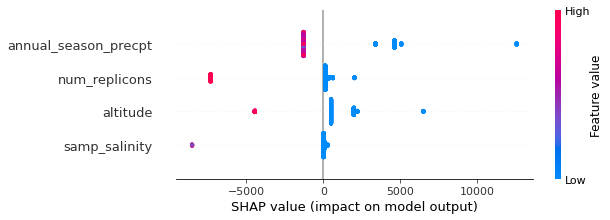

In [93]:
shap_values_all = explainer_all.shap_values(X)
shap.summary_plot(shap_values_all, X, feature_names = cb_model.feature_names[sorted_feature_importance],show=False)#,matplotlib=True).savefig('SHAP.pdf',bbox_inches = 'tight')


